## London Crime by Lower Super Output Area (LSOA)

## About Dataset
#### Context
- London is the capital and most populous city of England and the United Kingdom. Standing on the River Thames in the south east of the island of Great Britain, London has been a major settlement for two millennia. 
- Source: https://en.wikipedia.org/wiki/London

#### Content
- This data counts the number of crimes at two different geographic levels of London (LSOA and borough) by year, according to crime type. Includes data from 2008 to present. 
- 13M rows containing counts of criminal reports by month, LSOA borough, and major/minor category. This dataset contains:
    - lsoa_code: code for Lower Super Output Area in Greater London.
    - borough: Common name for London borough.
    - major_category: High level categorization of crime
    - minor_category: Low level categorization of crime within major category.
    - value: monthly reported count of categorical crime in given borough
    - year: Year of reported counts, 2008-2016
    - month: Month of reported counts, 1-12

#### Inspiration
- What is the change in the number of crime incidents from 2011 to 2016?
- What were the top 3 crimes per borough in 2016?

### Import Libraries and Dataset

In [111]:
# Melakukan import library yang akan digunakan
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas as gpd

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
tf.keras.backend.clear_session()

In [112]:
# Melakukan import dan menampilkan dataset
df_lc = pd.read_csv('london_crime_by_lsoa.csv')
df_lc.head()

,lsoa_code,borough,major_category,minor_category,value,year,month
0,E01001116,Croydon,Burglary,Burglary in Other Buildings,0,2016,11
1,E01001646,Greenwich,Violence Against the Person,Other violence,0,2016,11
2,E01000677,Bromley,Violence Against the Person,Other violence,0,2015,5
3,E01003774,Redbridge,Burglary,Burglary in Other Buildings,0,2016,3
4,E01004563,Wandsworth,Robbery,Personal Property,0,2008,6


In [113]:
df_lc.shape

(13490604, 7)

Dataset yang akan digunakan, yaitu dataset London Crime by  Lower Super Output Area (LSOA) terdiri dari 13490604 baris dan 7 kolom.

In [114]:
# Menampilkan informasi berupa kolom dan tipe data pada setiap kolom
df_lc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13490604 entries, 0 to 13490603
Data columns (total 7 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   lsoa_code       object
 1   borough         object
 2   major_category  object
 3   minor_category  object
 4   value           int64 
 5   year            int64 
 6   month           int64 
dtypes: int64(3), object(4)
memory usage: 720.5+ MB


### Preprocessing

In [115]:
# Mengubah nama kolom pada dataset dc_lc
df_lc.columns = ['LSOA_Code', 'Borough', 'Major_Category', 'Minor_Category', 'Value', 'Year', 'Month']
df_lc.head()

,LSOA_Code,Borough,Major_Category,Minor_Category,Value,Year,Month
0,E01001116,Croydon,Burglary,Burglary in Other Buildings,0,2016,11
1,E01001646,Greenwich,Violence Against the Person,Other violence,0,2016,11
2,E01000677,Bromley,Violence Against the Person,Other violence,0,2015,5
3,E01003774,Redbridge,Burglary,Burglary in Other Buildings,0,2016,3
4,E01004563,Wandsworth,Robbery,Personal Property,0,2008,6


In [116]:
# Menampilkan jumlah data yang memiliki nilai null pada dataset.
df_lc.isnull().sum()

LSOA_Code         0
Borough           0
Major_Category    0
Minor_Category    0
Value             0
Year              0
Month             0
dtype: int64

In [117]:
# Menampilkan data yang memiliki nilai duplikat pada dataset.
sum(df_lc.duplicated())

0

In [118]:
# Membuat dataframe baru dengan menghilangkan 'Value' yang bernilai 0
df_lc = df_lc.loc[df_lc['Value'] != 0]
df_lc.head()

,LSOA_Code,Borough,Major_Category,Minor_Category,Value,Year,Month
9,E01004177,Sutton,Theft and Handling,Theft/Taking of Pedal Cycle,1,2016,8
16,E01000086,Barking and Dagenham,Theft and Handling,Other Theft Person,1,2009,5
24,E01001301,Ealing,Theft and Handling,Other Theft Person,2,2012,1
25,E01001794,Hackney,Violence Against the Person,Harassment,1,2013,2
32,E01000733,Bromley,Criminal Damage,Criminal Damage To Motor Vehicle,1,2016,4


### Exploratory Data Analysis (EDA)

#### 1. What is the change in the number of crime incidents from 2011 to 2016?

In [119]:
df_lc_year= pd.DataFrame(df_lc.groupby('Year')['Value'].sum())
df_lc_year.columns = ['Total_Crime']
df_lc_year

,Total_Crime
Year,
2008,738641
2009,717214
2010,715324
2011,724915
2012,737329
2013,686407
2014,680183
2015,711624
2016,736121


Membuat dataframe baru, yaitu df_lc_year yang berisi kolom Year sebagai index dan kolom value yang berisi total kejahatan setiap tahunnya. 

In [120]:
df_lc_year_subset= df_lc_year.loc[2011:2016]
df_lc_year_subset

,Total_Crime
Year,
2011,724915
2012,737329
2013,686407
2014,680183
2015,711624
2016,736121


Membuat dataset 'df_lc_year_subset' yang berisi data kejahatan selama 5 tahun terkini, yaitu 2011 hingga 2016.

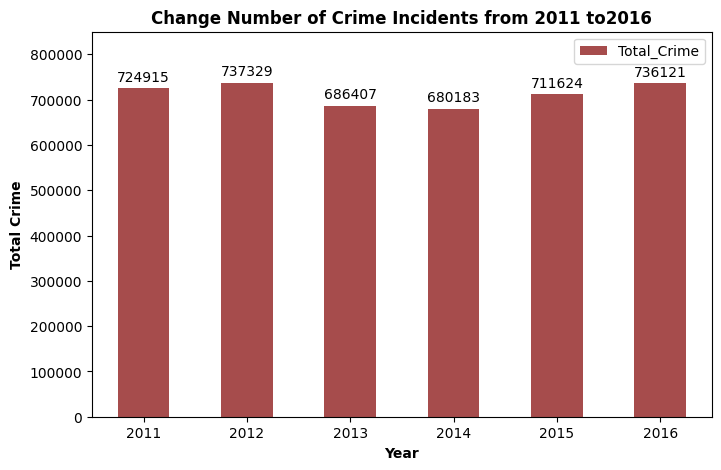

In [121]:
# Plot DataFrame yang sudah disubset
ax = df_lc_year_subset.plot(kind='bar',
                            figsize=(8,5),
                            alpha=0.7,
                            color='maroon',
                            rot = 0)


plt.title('Change Number of Crime Incidents from 2011 to2016', fontsize = 12, fontweight = 'bold')
plt.ylabel('Total Crime', fontweight = 'bold')
plt.xlabel('Year', fontweight = 'bold')


# Menambahkan jumlah angka pada setiap batang
for p in ax.patches:
    ax.annotate(str(p.get_height()),
                (p.get_x() + p.get_width()/2.,p.get_height()),
                ha = 'center',
                va = 'center',
                textcoords='offset points',
                xytext = (0,8)
               )
    
# Mengatur batas sumbu y
plt.ylim(0, 850000)

# Menampilkan grafik
plt.show()

Berdasarkan grafik yang telah ditampilkan dari data, dapat dilihat bahwa dari tahun 2011-2016 jumlah kejahatan yang terjadi di London memiliki angka yang masih fluktuatif. Berikut adalah analisisnya:
1. Pada tahun 2011, jumlah kejahatan di London mengalami peningkatan dibandingkan tahun sebelumnya.
2. Pada tahun 2012, jumlah kejahatan yang tinggi di London menunjukkan bahwa pada tahun tersebut merupakan puncak dari kejahatan selama 5 tahun terakhir.
3. Pada tahun 2013-2014, terjadi penurunan jumlah kejahatan yang signifikan dibandingkan tahun sebelumnya, yang menunjukkan adanya upaya yang berhasil mengurangi tingkat kejahatan.
4. Pada tahun 2014-2015, jumlah kejahatan kembali mengalami peningkatan yang menandakan adanya fluktuasi.



#### 2. What is the year with the biggest number of crime incidents from 2008 to 2016?

In [122]:
df_lc_year = df_lc_year.sort_values(['Total_Crime'], ascending=False)
df_lc_year

,Total_Crime
Year,
2008,738641
2012,737329
2016,736121
2011,724915
2009,717214
2010,715324
2015,711624
2013,686407
2014,680183


Membuat dataframe 'df_lc_year' yang berisi data dengan index yang diurutkan berdasarkan jumlah kejahatan.

In [123]:
df_lc_year_subset = df_lc_year.head()
df_lc_year_subset

,Total_Crime
Year,
2008,738641
2012,737329
2016,736121
2011,724915
2009,717214


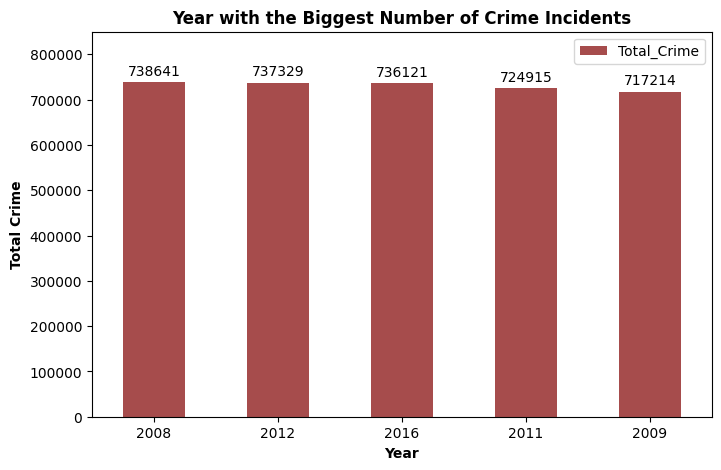

In [124]:
# Plot dataframe yang sudah disubset
ax = df_lc_year_subset.plot(kind = 'bar',
                            figsize = (8,5),
                            alpha = 0.7,
                            color = 'maroon',
                            rot = 0
                           )

# Judul dan label
plt.title('Year with the Biggest Number of Crime Incidents', fontsize = 12, fontweight = 'bold')
plt.ylabel('Total Crime', fontweight = 'bold')
plt.xlabel('Year', fontweight = 'bold')

# Menambahkan angka pada setiap batang
for p in ax.patches:
    ax.annotate(str(p.get_height()),
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha = 'center',
                va = 'center',
                textcoords='offset points',
                xytext = (0,8)
               )
    
# Mengatur batas sumbu y
plt.ylim(0, 850000)

# Menampilkan grafik
plt.show()

Berdasarkan data dari tahun 2008-2016, jumlah kejahatan yang paling tinggi di London terjadi pada tahun 2008, 2012, 2016, 2011, dan 2009.
Berikut adalah analisisnya:

1. Tahun 2008 merupakan tahun dengan angka kejahatan paling tinggi selama rentang waktu 2008-2016, hal ini mungkin terjadi karena kurangnya regulasi tentang tindak kejahatan di tahun tersebut.
2. Tahun 2012 merupakan jumlah kejahatan yang paling tinggi di London selama 5 tahun terakhir.
3. Tahun 2016, jumlah kejahatan terbilang masih tinggi yang menujukkan adanya kondisi sosial-ekonomi yang kurang menguntungkan atau kurangnya efektivitas dalam penegakan hukum.

#### 3. What is the change in the number of crime incidents from January to December in 2016?

In [125]:
df_lc_month = df_lc[(df_lc['Year'] == 2016)]
df_lc_month = pd.DataFrame(df_lc_month.groupby('Month')['Value'].sum())
df_lc_month.index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df_lc_month

,Value
Jan,58847
Feb,56697
Mar,59167
Apr,58637
May,63990
Jun,62262
Jul,65519
Aug,62666
Sep,61412
Oct,63405


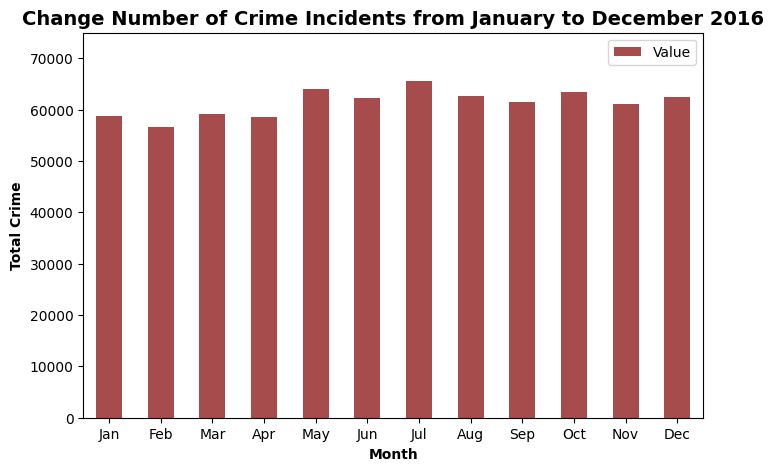

In [126]:
ax = df_lc_month.plot(kind = 'bar',
                      figsize = (8, 5),
                      alpha = 0.7,
                      color = 'maroon',
                      rot = 0
                     )
# Judul dan label
plt.title('Change Number of Crime Incidents from January to December 2016', fontweight = 'bold', fontsize = 14)
plt.xlabel('Month', fontweight = 'bold')
plt.ylabel('Total Crime', fontweight = 'bold')

# Mengatur batas sumbu y
plt.ylim(0, 75000)

# Menampilkan grafik
plt.show()

Menampilkan angka kejahatan selama tahun 2016 yang mana hasil visualisasi menunjukkan bahwa kejahatan paling banyak dilakukan pada bulan Mei, Juli, dan Oktober. Dari hasil tersebut, pihak terkait dapat memberikan penanggulangan agar pada tahun berikutnya angka kejahatan dapat menurun.

#### 4. What were the top 5 borough with the highest crime rates in 2016?

In [127]:
df_year_2016 = df_lc[(df_lc['Year'] == 2016)]
df_year_2016 = pd.DataFrame(df_year_2016.groupby(['Borough'])['Value'].sum())
df_year_2016.columns = ['Total_Crime']
df_year_2016 = df_year_2016.sort_values('Total_Crime')
df_year_2016_highest = df_year_2016.tail()
df_year_2016_highest

,Total_Crime
Borough,
Tower Hamlets,29253
Newham,30090
Southwark,31636
Lambeth,34071
Westminster,48330


Membuat dataframe 'df_year_2016' yang berisi data jumlah kejahatan yang dikelompokkan berdasarkan wilayah di London.

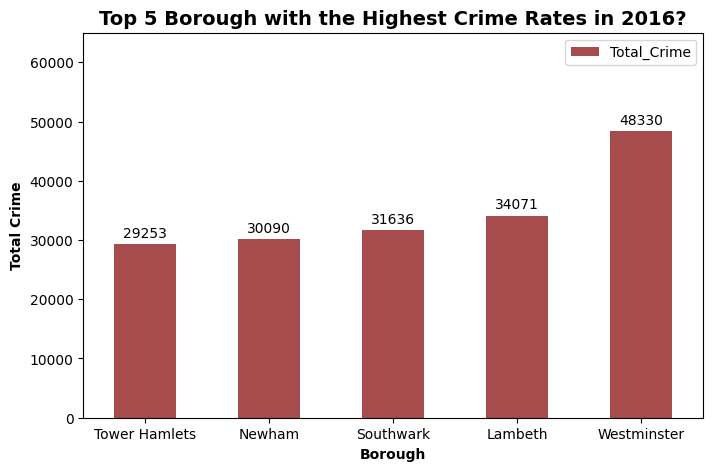

In [128]:
ax = df_year_2016_highest.plot(kind = 'bar',
                               figsize = (8,5),
                               alpha = 0.7,
                               color = 'maroon',
                               rot = 0)

# Judul dan label
plt.title('Top 5 Borough with the Highest Crime Rates in 2016?', fontsize = 14, fontweight = 'bold')
plt.xlabel('Borough', fontweight = 'bold')
plt.ylabel('Total Crime', fontweight = 'bold')

# Menambahkan angka pada setiap batang
for p in ax.patches:
    ax.annotate(str(p.get_height()),
               (p.get_x() + p.get_width() / 2. , p.get_height()),
               ha = 'center',
               va = 'center',
               textcoords = 'offset points',
               xytext = (0, 8))

# Mengatur batas sumbu y
plt.ylim(0, 65000)

# Menampilkan grafik
plt.show()

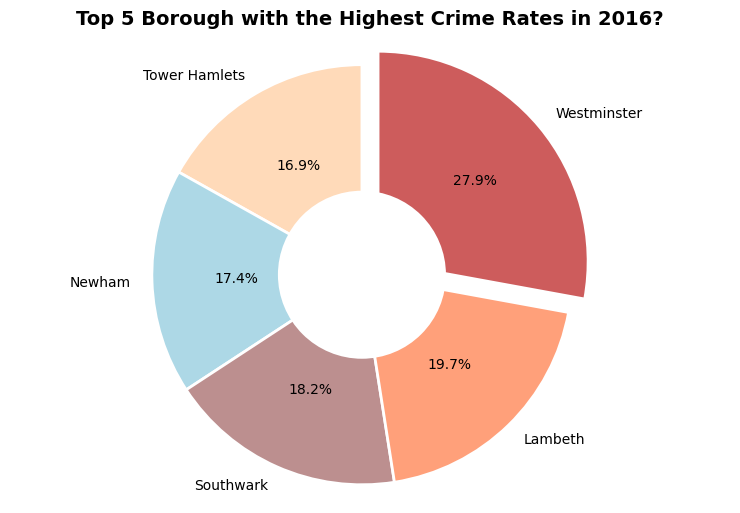

In [129]:
# Membuat dataframe baru
total_crime = df_year_2016_highest['Total_Crime']
#Menentukan label untuk setiap kategori
label_list = df_year_2016_highest.index
# Menentukan warna untuk setiap kategori
color_list = ['peachpuff', 'lightblue', 'rosybrown', 'lightsalmon', 'indianred']
 # ['lightblue', 'indianred', 'peachpuff']
# Menentukan besarnya explode untuk setiap kategori
explode_list = [0, 0, 0, 0, 0.1]

# Menentukan ukuran visualisasi
fig1, ax1 = plt.subplots(figsize = (7.5, 5))

plt.pie(total_crime,
        labels = label_list,
        autopct = '%1.1f%%',
        startangle = 90,
        explode = explode_list,
        colors = color_list,
        wedgeprops = {'linewidth' : 2, 'edgecolor' : 'white'},
        textprops={ 'verticalalignment': 'center'}
       )

centre_circle = plt.Circle((0, 0), 0.4, fc = 'white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax1.axis('equal')
plt.tight_layout()

# Judul
plt.title('Top 5 Borough with the Highest Crime Rates in 2016?', fontsize = 14, fontweight = 'bold')

# Menampilkan grafik
plt.show()

Menampilkan wilayah dengan angka kejahatan paling tinggi di London pada tahun 2016, yaitu Westminster, Lambeth, Southwark, Newham, dan Tower Hamlets. Berikut adalah analisisnya:
1. Wilayah dengan angka kejahatan paling tinggi di London pada tahun 2016 adalah Westminster sebesar 27.9% dari total lima wilayah dengan angka kejahatan tertinggi dengan total kejahatan 48330. Westminster merupakan salah satu wilayah yang luas dengan populasi yang tinggi karena wilayah ini merupakan kawasan wisata dan pusat politik Kerajaan Iggris.
2. Pada posisi kedua, wilayah dengan angka kejahatan yang tinggi adalah Lambeth, yaitu sebesar 19.7% dari total lima wilayah dengan angka kejahatan paling tinggi dengan total kejahatan 34071. Lambeth merupakan wilayah yang terkenal di London karena merupakan pencipta UK Drill, yaitu gaya musik atau subgenre yang berafiliasi dengan geng atau berasal dari lingkungan yang kekurangan ekonomi dan kemampuan sosial sehingga kejahatan menjadi cara untuk bertahan hidup. 
3. Pada posisi ketiga, wilayah dengan angka kejahatan yang tinggi adalah Southwark, yaitu 18.2% dari total lima wilayah dengan angka kejahatan  paling tinggi dengan total kejahatan 31636. Southwark merupakan wilayah dengan angka kejahatan yang tinggi karena setiap orang memiliki kemungkinan atas kepemilikan senjata api.
4. Pada posisi keempat, wilayah dengan angak kejahatan yang tinggi adalah Newham, yaitu 17.4% dari total lima wilayah dengan angka kejahatan paling tinggi dengan total kejahatan 30090. Dilaporkan bahwa sebanyak 800 kejahatan terjadi per km² dalam satu tahun.
5. Pada posisi kelima, wilayah dengan angak kejahatan yang tinggi adalah Tower Hamlets, yaitu 16.9% dari total lima wilayah dengan angka kejahatan paling tinggi dengan total kejahatan 29253. Tower Hamlets memiliki angka kejahatan yang tinggi karena faktor sosial ekonomi dan kepadatan penduduk yang tinggi.

#### 5. What were the top 3 crimes per borough in 2016?

In [130]:
#Menentukan urutan Borough berdasarkan angka kejahatan
boroughs = ['Westminster', 'Lambeth', 'Southwark', 'Newham', 'Tower Hamlets']

# Filter berdasarkan tahun 2016 dan daftar borough pada 'borough'
df_borough = df_lc[(df_lc['Year'] == 2016) & (df_lc['Borough'].isin(boroughs))].copy()

# Mengatur urutan index berdasarkan Borough
df_borough.loc[: , 'Borough'] = pd.Categorical(df_borough['Borough'], categories = boroughs, ordered = True)

# Mengelompokkan berdasarkan Borough dan Major Category, kemudian menjumlahkan nilai Value dan menghapus index
df_borough = pd.DataFrame(df_borough.groupby(['Borough', 'Major_Category'])['Value'].sum().reset_index())

df_borough.head()

C:\Users\lenovo\AppData\Local\Temp\ipykernel_7608\2391364030.py:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_borough.loc[: , 'Borough'] = pd.Categorical(df_borough['Borough'], categories = boroughs, ordered = True)


,Borough,Major_Category,Value
0,Westminster,Burglary,3218
1,Westminster,Criminal Damage,2179
2,Westminster,Drugs,2049
3,Westminster,Other Notifiable Offences,708
4,Westminster,Robbery,1822


In [131]:
# Memilih dua kategori utama berdasarkan total kejahatan pada Major_Category yang paling besar
top_categories = df_borough.groupby('Major_Category')['Value'].sum().nlargest(3).index.tolist()
df_borough = df_borough[df_borough['Major_Category'].isin(top_categories)]
df_borough = pd.DataFrame(df_borough.groupby(['Borough', 'Major_Category']).sum())
df_borough

Value
Borough       Major_Category                    
Westminster   Burglary                      3218
              Theft and Handling           27520
              Violence Against the Person  10834
Lambeth       Burglary                      3087
              Theft and Handling           13155
              Violence Against the Person  10496
Southwark     Burglary                      2946
              Theft and Handling           12946
              Violence Against the Person   9474
Newham        Burglary                      2115
              Theft and Handling           11964
              Violence Against the Person   9646
Tower Hamlets Burglary                      2794
              Theft and Handling           10953
              Violence Against the Person   9608

Dari data di atas dapat disimpulkan bahwa  kejahatan yang paling banyak dilakukan pada 5 wilayah dengan angka kejahatan paling tinggi adalah Theft and Handling dan Violence Against the Person. 

In [132]:
# Menghapus index untuk melakukan pivot table
df_borough = df_borough.reset_index()

# Melakukan pivot dengan index Borough dan column Major_Category
df_borough = df_borough.pivot(index = 'Borough', columns = 'Major_Category', values = 'Value')
df_borough

Major_Category,Burglary,Theft and Handling,Violence Against the Person
Borough,,,
Westminster,3218,27520,10834
Lambeth,3087,13155,10496
Southwark,2946,12946,9474
Newham,2115,11964,9646
Tower Hamlets,2794,10953,9608


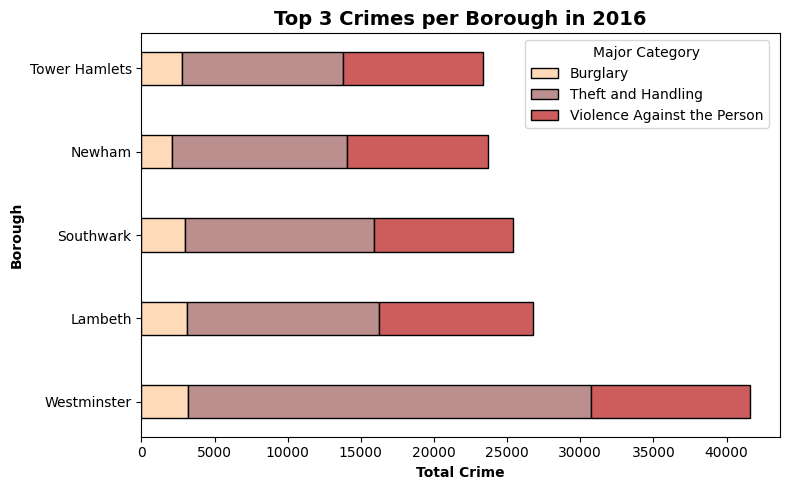

In [133]:
# Menentukan warna untuk setiap kategori
color_list = ['peachpuff', 'rosybrown','indianred']

# Plot menggunakan matplotlib untuk kontrol lebih baik
fig, ax = plt.subplots(figsize=(8, 5))

# Lebar batang
bar_width = 0.4

# Plot setiap kategori
for i, category in enumerate(df_borough.columns):
    ax.barh(df_borough.index, df_borough[category], 
            color = color_list[i], 
            alpha = 1, 
            edgecolor = 'black', 
            height = bar_width, 
            label = category, 
            left = df_borough.iloc[:, :i].sum(axis = 1) if i > 0 else 0)

# Judul dan label
plt.title('Top 3 Crimes per Borough in 2016', fontweight='bold', fontsize=14)
plt.xlabel('Total Crime', fontweight = 'bold')
plt.ylabel('Borough', fontweight = 'bold')

# Legenda
ax.legend(title='Major Category', bbox_to_anchor = (0.59, 1), loc = 'upper left')

# Tata letak
plt.tight_layout()

# Menampilkan plot
plt.show()

Berdasarkan data 2016, jumlah kejahatan yang paling tinggi di London tepatnya di 5 wilayah dengan kejahatan tertinggi adalah Violence Against the Person, Theft and Handling, dan Burglary. Berikut adalah analisisnya:
1. Kekerasan terhadap Orang (Violence Against the Person): Tingginya kepadatan penduduk dan kompleksitas sosial di beberapa wilayah ini berkontribusi pada insiden kekerasan interpersonal yang lebih tinggi.
2. Pencurian dan Penanganan (Theft and Handling): Adanya banyak pusat perbelanjaan, bisnis, dan tempat wisata meningkatkan peluang untuk terjadinya pencurian dan penanganan barang curian.
3. Perampokan (Burglary): Ketimpangan ekonomi dan aksesibilitas yang baik mempengaruhi tingkat perampokan, terutama di daerah dengan tingkat pengangguran yang tinggi atau wilayah dengan kepadatan rumah yang tinggi.

#### 6. Create a folium map of the borough in London

In [134]:
# Mengimpor file shapefile
london_map = gpd.read_file('London_Borough_Excluding_MHW.shp')

# Mengelompokkan dan menjumlahkan kejahatan per 'Borough'
borough_crimes = df_lc.groupby('Borough')['Value'].sum()

# Menggabungkan data geografis dengan data kejahatan
joined = london_map.set_index('NAME').join(borough_crimes)

In [135]:
# Mendapatkan koordinat dari titik representatif untuk setiap geometri dalam dataFrame
joined['coords'] = joined['geometry'].\
apply (lambda x: x.representative_point().coords[:])
joined['coords'] = [coords[0] for coords in joined['coords']]

C:\Users\lenovo\AppData\Local\Temp\ipykernel_7608\637231398.py:20: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(scalarMap, shrink = 1)


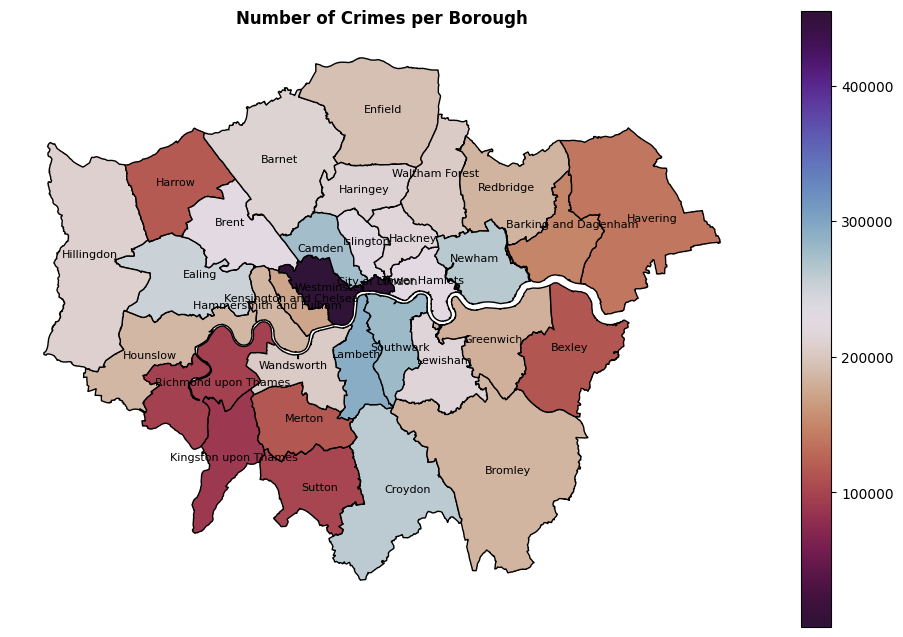

In [136]:
# Plotting peta
joined.plot(column = 'Value',
            cmap = 'twilight_shifted_r',
            linewidth = 1,
            edgecolor = 'black',
            figsize = (12, 8)
           )

# Mengatur tampilan peta
plt.axis('off')
plt.title('Number of Crimes per Borough', fontweight = 'bold')

# Menambahkan colorbar
scalarMap = plt.cm.ScalarMappable(cmap = 'twilight_shifted_r',
                                  norm = plt.Normalize(vmin = min(joined['Value']),
                                                       vmax = max(joined['Value'])
                                                      )
                                 )
scalarMap._A = []
cbar = plt.colorbar(scalarMap, shrink = 1)

# Menambahkan anotasi nama borough
for idx, row in joined.iterrows():
    plt.annotate(text = idx,
                 xy = row['coords'],
                 horizontalalignment = 'center',
                 fontsize = 8                
                )

#### 7. Create Prediction for Westminster 

In [137]:
# Membuat dataset baru yang berisi data wilayah Westminster dari tahin 2008-2016
df_w = df_lc[(df_lc['Borough'] == 'Westminster')]

# Membuat dataframe yang berisi kolom Year, Month, dan Value
df_w = pd.DataFrame(df_w.groupby(['Year', 'Month'])['Value'].sum())
df_w = df_w.reset_index()
df_w

,Year,Month,Value
0,2008,1,3957
1,2008,2,3880
2,2008,3,3896
3,2008,4,3725
4,2008,5,3849
...,...,...,...
103,2016,8,4291
104,2016,9,3773
105,2016,10,4093
106,2016,11,4275


In [138]:
# Gabungkan kolom 'Year' dan 'Month' menjadi satu kolom string
df_w['Time'] = df_w['Year'].astype(str) + '-' + df_w['Month'] .astype(str)

# Ubah kolom 'Time' menjadi tipe datetime
df_w['Time'] = pd.to_datetime(df_w['Time'], format = '%Y-%m')

# Mengatur kolom 'Time' menjadi index
df_w.set_index('Time', inplace = True)

# Menghapus kolom Year dan Month
df_w = df_w.drop(columns = {'Year', 'Month'})
df_w.head()

,Value
Time,
2008-01-01,3957
2008-02-01,3880
2008-03-01,3896
2008-04-01,3725
2008-05-01,3849


<Axes: xlabel='Time'>

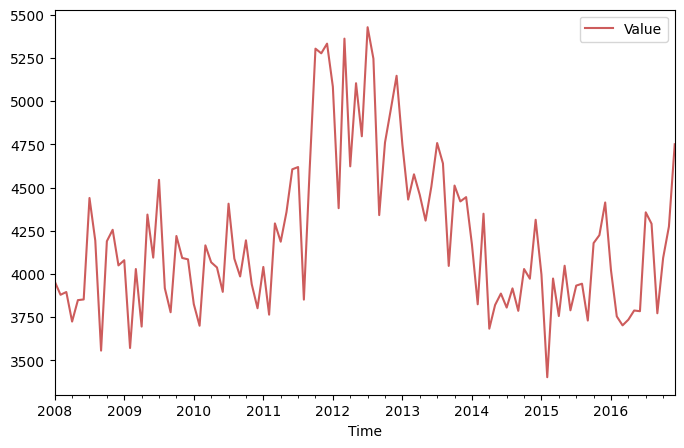

In [139]:
# Menampilkan plot
df_w.plot(figsize = (8, 5),
          color = 'indianred'
         )

In [140]:
# Menampilkan panjang data
len(df_w)

108

In [141]:
# Membagi DataFrame menjadi set pelatihan dan set pengujian
data_train = df_w[:98]
data_test = df_w[98:]

In [142]:
# Inisialisasi MinMaxScaler
scaler = MinMaxScaler()

# Melakukan training dengan data train
scaler.fit(data_train)

# Melakukan transform data
scaled_train = scaler.transform(data_train)
scaled_test = scaler.transform(data_test)

In [143]:
# Menampilkan scaled data testing
scaled_test[:10]

array([[0.14814815],
       [0.16444444],
       [0.19061728],
       [0.18864198],
       [0.47111111],
       [0.43851852],
       [0.18271605],
       [0.34074074],
       [0.43061728],
       [0.66567901]])

In [144]:
# Melakukan konfigurasi parameter dan generator data
n_input = 10
n_features = 1

generator = TimeseriesGenerator(scaled_train, 
                                scaled_train,
                                length = n_input,
                                batch_size = 8
                               )

In [145]:
X, y = generator[0]

print(f'Diberikan array sebagai berikut: \n{X.flatten()}')
print(f'Prediksi y berikut: \n {y}')

Diberikan array sebagai berikut: 
[0.27358025 0.23555556 0.24345679 0.15901235 0.22024691 0.22222222
 0.51209877 0.39012346 0.07604938 0.38864198 0.23555556 0.24345679
 0.15901235 0.22024691 0.22222222 0.51209877 0.39012346 0.07604938
 0.38864198 0.42123457 0.24345679 0.15901235 0.22024691 0.22222222
 0.51209877 0.39012346 0.07604938 0.38864198 0.42123457 0.31950617
 0.15901235 0.22024691 0.22222222 0.51209877 0.39012346 0.07604938
 0.38864198 0.42123457 0.31950617 0.33432099 0.22024691 0.22222222
 0.51209877 0.39012346 0.07604938 0.38864198 0.42123457 0.31950617
 0.33432099 0.08345679 0.22222222 0.51209877 0.39012346 0.07604938
 0.38864198 0.42123457 0.31950617 0.33432099 0.08345679 0.3091358
 0.51209877 0.39012346 0.07604938 0.38864198 0.42123457 0.31950617
 0.33432099 0.08345679 0.3091358  0.14469136 0.39012346 0.07604938
 0.38864198 0.42123457 0.31950617 0.33432099 0.08345679 0.3091358
 0.14469136 0.46469136]
Prediksi y berikut: 
 [[0.42123457]
 [0.31950617]
 [0.33432099]
 [0.08345

In [146]:
# Membuat model neural network Sequential
model = Sequential()

# Menambahkan layer LSTM ke dalam model dengan 100 unit LSTM
model.add(LSTM(100, 
               activation = 'sigmoid', 
               input_shape = (n_input, n_features)))

# Menambahkan output layer 
model.add(Dense(1))

# Mengunakan fungsi optimasi Adam  dengan fungsi loss MSE
model.compile(optimizer = 'adam', 
              loss = 'mse')

In [147]:
# Melatih model dengan data training sebanyak 1000 epoch
model.fit(generator, epochs = 10000)

Epoch 1/10000
11/11 [==============================] - 4s 13ms/step - loss: 0.1444
Epoch 2/10000
11/11 [==============================] - 0s 21ms/step - loss: 0.0784
Epoch 3/10000
11/11 [==============================] - 0s 12ms/step - loss: 0.0646
Epoch 4/10000
11/11 [==============================] - 0s 12ms/step - loss: 0.0585
Epoch 5/10000
11/11 [==============================] - 0s 12ms/step - loss: 0.0547
Epoch 6/10000
11/11 [==============================] - 0s 11ms/step - loss: 0.0588
Epoch 7/10000
11/11 [==============================] - 0s 12ms/step - loss: 0.0627
Epoch 8/10000
11/11 [==============================] - 0s 12ms/step - loss: 0.0604
Epoch 9/10000
11/11 [==============================] - 0s 11ms/step - loss: 0.0494
Epoch 10/10000
11/11 [==============================] - 0s 11ms/step - loss: 0.0551
Epoch 11/10000
11/11 [==============================] - 0s 11ms/step - loss: 0.0493
Epoch 12/10000
11/11 [==============================] - 0s 12ms/step - loss: 0.0619
E

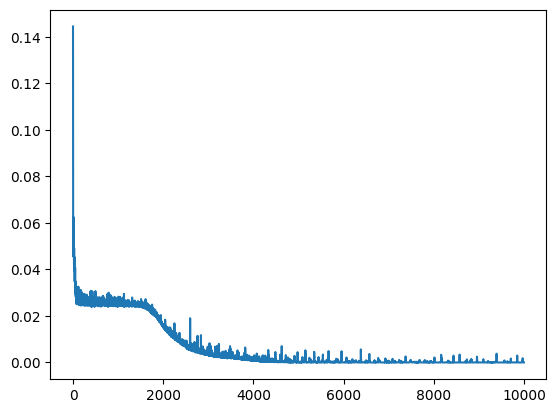

In [148]:
# Menampilkan plot yang menunjukkan nilai loss pada setiap epoch
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [149]:
# Mengambil 10 data terakhir dari data training
last_train_batch = scaled_train[-10:]

# Mengubah bentuk
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

# Memprediksi nilai berdasarkan last_train_batch
model.predict(last_train_batch)

1/1 [==============================] - 1s 531ms/step


array([[0.3788181]], dtype=float32)

In [150]:
# Menampilkan data uji yang telah dinormalisasikan
scaled_test[0]

array([0.14814815])

In [151]:
# Mengubah bentuk last_train_batch
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [152]:
# Menginisialisasi test_predictions untuk menyimpan prediksi pada data testing
test_predictions = []

# Mengambil data dari data training
first_eval_batch = scaled_train[-n_input:]

# Mengubah bentuk first_eval_batch
current_batch = first_eval_batch.reshape((1, n_input, n_features))

# Melakukan iterasi sesuai panjang data testing
for i in range(len(data_test)):

    # get the prediction value for the first batch
    # Memprediksi nilai dengan batch saat ini
    current_pred = model.predict(current_batch)[0]

    # Menambahkan prediksi dalam current_pend
    test_predictions.append(current_pred)

    # Memperbarui batch saat ini dengan menggeser data ke kiri dengan menggunakan hasil prediksi
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 34ms/step


In [153]:
# Menampilkan hasil prediksi
test_predictions

[array([0.3788181], dtype=float32),
 array([0.2560713], dtype=float32),
 array([0.29403636], dtype=float32),
 array([0.17628007], dtype=float32),
 array([0.1909936], dtype=float32),
 array([0.40118375], dtype=float32),
 array([0.3419002], dtype=float32),
 array([0.32599667], dtype=float32),
 array([0.3615066], dtype=float32),
 array([0.51193136], dtype=float32)]

In [154]:
# Melakukan denormalisasi untuk mengembalikan skala nilai 
true_predictions = scaler.inverse_transform(test_predictions)

In [155]:
# Menambahkan kolom predictions yang berisi hasil prediksi
test = data_test.copy()
test['Predictions'] = true_predictions
true_predictions

array([[4170.10664183],
       [3921.54438111],
       [3998.42362615],
       [3759.9671344 ],
       [3789.76205426],
       [4215.39710227],
       [4095.34790429],
       [4063.14325097],
       [4135.0508875 ],
       [4439.66100353]])

<Axes: xlabel='Time'>

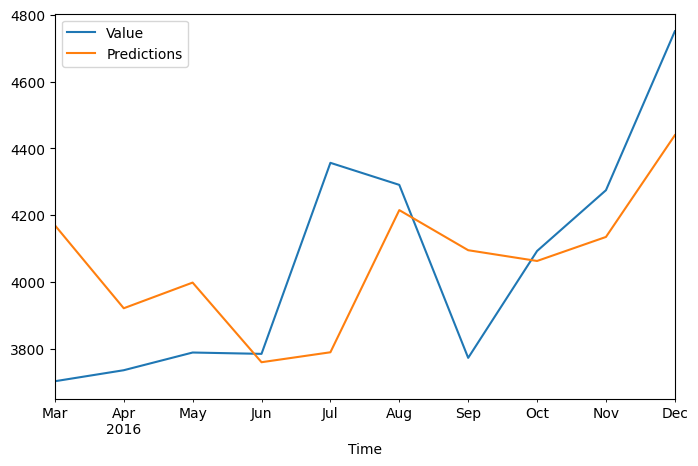

In [156]:
# Melakukan plot data hasil prediksi dan data asli
test.plot(figsize = (8, 5))

In [157]:
# Mendapatkan nilai aktual dan prediksi
actual = test['Value']
predicted = test['Predictions']

# Menghitung MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((actual - predicted) / actual)) * 100
print("MAPE:", mape)

MAPE: 5.764987420929797


Berikut ini merupakan hasil perbandingan penggunaan jumlah epochs 7000 dan 10000 saat proses training.
- epochs = 7000
    - 9.137841733429255
    - 9.178446888000883
    - 8.730232286291715
- epoch = 10000
    - 7.521568091243383
    - 7.2543001285374125
    - 4.35389777781483
    - 7.559884505672467
    - 7.226258392311973
    - 6.867357955722723
    - 5.552724204762177
    - 6.533901108528761
    - 7.2213128255490355
    - 5.764987420929797
- Rata-rata:
6.601054902
- 
- 
- 




- Dari hasil yang diperoleh dapat disimpulkan bahwa metode LSTM dengan penggunaan batch size 8 dan epoch 10000 menghasilkan nilai MAPE yang optimal pada penggunaan data London Crime by LSOA dengan jumlah data 108 dengan rentang data per bulan dan proporsi data training 98 data testing 10. 
- Menurut Lewis (1982), interpretasi nilai MAPE atau target MAPE terbagi menjadi 4 kategori.
    - MAPE: <10%        --> Sangat baik
    - MAPE: 10% - 19%   --> Baik
    - MAPE: 20% - 49%   --> Wajar
    - MAPE: ≥50%        --> Tidak 

- Rata-rata yang diperoleh pada penerapan LSTM untuk prediksi data adalah 6.601054902. Nilai tersebut digolongkan pada kategori sangat baik karena nilainya <10% sehingga dapat disimpulkan bahwa performa metode LSTM sangat baik digunakan pada proses prediksi data ini.

Referensi
- Lewis, C. (1982). Industrial and Business Forecasting Methods. London:
Butterworth Scientific.
